# Kolmogorov-Smirnov Test

The Komogorov-Smirnov (KS) test is desined to detect differences in observed distributions from a model. This test is typically used when you have lots of data available (which is of course the typical scenario you'll be working in). It's not always the most powerful test because its designed to catch all kinds of deviations from your model. It comes in two versions, the 1-sample and 2-sample versions, which we'll cover in this notebook. 

In [1]:
%matplotlib inline

import numpy,pandas,random
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

## 1-sample KS test

I've put a file `data_ks.csv` which contains data represented by a random variable $X$. Each entry in the file is an independent random instance of the random variable $X$. 

In [2]:
data_ks = pandas.read_csv("data_ks.csv")
data_ks.head()

,data_x
0,11.090667
1,4.846509
2,8.922837
3,7.235258
4,4.033250


We can make a histogram of the data to see how the events are distributed. 


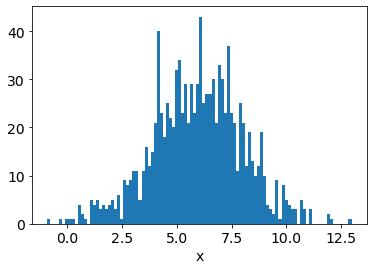

In [3]:
data_ks = data_ks["data_x"].to_numpy()
plt.hist(data_ks,bins=100)
plt.xlabel("x")
plt.show()

The distribution looks like it could be Gaussian. We can make a hypothesis that the correct probability distribution is a Gaussian distribution. How about we calculate the mean and standard deviation of the data as a good estimate of the parameters $\mu$ and $\sigma$ - remember the method of moments!

In [4]:
mu    = numpy.mean(data_ks)
sigma = numpy.std(data_ks)

print("mu =",mu,", sigma =",sigma)

mu = 5.945319961951154 , sigma = 2.0638932385824162


So we define our *null*  hypothesis $H_{0}$ as a Gaussian probability density with parameters equal to $\mu=5.945, \sigma=2.064$. 

Let's see how well a Gaussian with these parameter values agrees with the data 

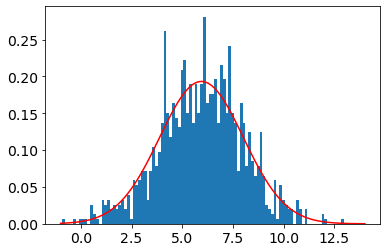

In [5]:
xrange = numpy.linspace(-1,14,100)

plt.hist(data_ks,bins=100,density=True)
plt.plot(xrange,norm.pdf(xrange,mu,sigma),color='red')
plt.show()

We can test the hypothesis that the data are distributed according to a Gaussian distribution with those parameters using the 1-sample KS test. 

The KS test is based on the *cumulative distribution function* of the model vs the *empirical cumulative distribution* of the data. The empirical distribution $F_{data}(x)$ is given by, 

$$
F_{data}(x) = \frac{\mathrm{number~of~data~values~} < x}{n}
$$

where $n$ is the number of entries in our data set. 

In [6]:
# We are passing the sigma as an argument as we'll use it later
def cdf(sigma,x):
    return norm.cdf(x,mu,sigma)

def emp_cdf(data,x):
    return float(len(data[data < x]))/len(data)

Lets look at the comparison of these two CDFs 

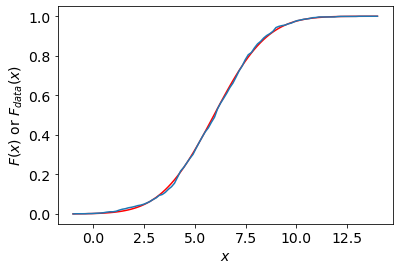

In [7]:
plt.plot(xrange,[cdf(sigma,x) for x in xrange],color='red')
plt.plot(xrange,[emp_cdf(data_ks,x) for x in xrange])
plt.xlabel("$x$")
plt.ylabel("$F(x)$ or $F_{data}(x)$")
plt.show()

You can see that the CDF plots look rather close to one-another. The 1-sample KS test looks for deviations in these two distributions. First, we define the KS test-statistic, 

$$
D = \mathrm{sup}_{x}\left|F_{data}(x)-F(x)\right|
$$

What this measures is the largest value over $x$ of the difference between the two CDFs. 

In [8]:
def D(sigma,data):
    diffs = [abs(cdf(sigma,x)-emp_cdf(data,x)) for x in xrange]
    return max(diffs)

D_data = D(sigma,data_ks)
print("KS test statistic in data D_data =", D_data)

KS test statistic in data D_data = 0.017551243425812824


Now, remember, we are trying to see if we can reject our $H_0$ hypothesis, so we need to know the distribution of our test statistic $D$ under the null hypothesis. We can do that using pseudo data. We generate random values under our $H_0$ model and calculate the test-statistic. We should use the same number of events as we have in the real data. 

In [9]:
ntoys = 1000
D_toys =  []
for i in range(ntoys):
    data_t = norm.rvs(mu,sigma,size=len(data_ks))
    D_toys.append(D(sigma,data_t))

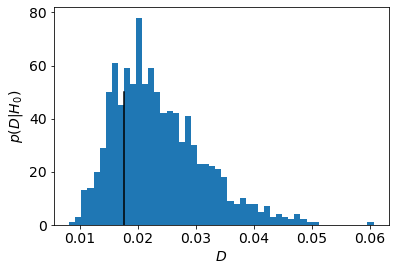

In [10]:
plt.hist(D_toys,bins=50)
plt.xlabel("$D$")
plt.ylabel("$p(D|H_{0})$")
plt.plot([D_data,D_data],[0,50],color='black')
plt.show()

Since larger values of $D$ would indicate worse agreement between the CDFs, our critical region should be constructed from large values of $D$. Suppose we want to set our type-1 error to be $\alpha=0.05$, we can look at $1-F(D)$ to see at which value of $D=D_{c}$, we find  $1-F(D) = p(D > D_{c}|H_{0})=0.05$. 

Text(0, 0.5, '1-F(D)')

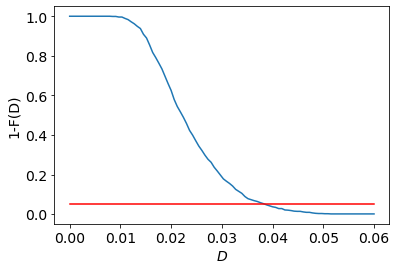

In [11]:
Drange = numpy.linspace(0,0.06,100)
D_toys = numpy.array(D_toys)

plt.plot(Drange,[1-float(len(D_toys[D_toys < x]))/len(D_toys) for x in Drange])
plt.plot([0,0.06],[0.05,0.05],color='red')
plt.xlabel("$D$")
plt.ylabel("1-F(D)")

You can see that the curve intersects the 0.05 line at around 0.038. This is much larger than our $D_{data}$ which means we cannot exclude the $H_{0}$ (null) hypothesis.

Given a fixed value of $\alpha=0.05$ we have a critical region of $D>0.038$. We might be interested in knowing what the *power* of this test is. Remember that we defined the power as the probability to reject $H_{0}$ given the alternate hypothesis $H_{1}$ is true. I.e, we would have,

$p(D>0.038|H_{1}) = 1-\beta = \mathrm{power}$.

But hold on, we don't have a $H_{1}$ yet so how can we calculate it? Well we have to try different $H_{1}$ and see how the power changes. Since we assumed a gaussian distribution with $\mu$ and $\sigma$, we can propose as alternative hypotheses, different values of the $\sigma$ parameter. 

In order to check the power for different values of $\sigma$, we can generate the distribution of $D$ under the hypothesis $H_{1}\rvert_{\sigma_{H_{1}}}$. Lets pick $\sigma_{H_{1}} = 1.9$

In [12]:
sigma_H1 = 1.9
D_toys_H1 = []
for i in range(ntoys):
  data_t = norm.rvs(mu,sigma_H1,size=len(data_ks))
  D_toys_H1.append(D(sigma_H1,data_t))


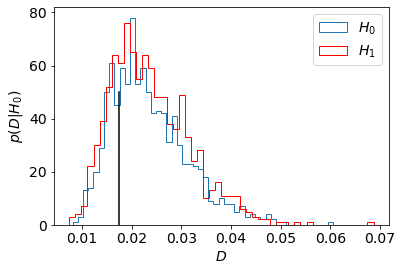

In [13]:
plt.hist(D_toys,bins=50,histtype='step',label="$H_{0}$")
plt.hist(D_toys_H1,bins=50,histtype='step',color='red',label="$H_{1}$")
plt.xlabel("$D$")
plt.ylabel("$p(D|H_{0})$")
plt.plot([D_data,D_data],[0,50],color='black')
plt.legend()
plt.show()

You can see that the distribution is quite similar between the two. In this case, the power would be quite small.

In [14]:
D_toys_H1 = numpy.array(D_toys_H1)
print("Power at sigma_H1=1.9",float(len(D_toys_H1[D_toys_H1 > 0.038]))/len(D_toys_H1))

Power at sigma_H1=1.9 0.057


We can see what this power looks like for other hypotheses $H_{1}$ (other values of $\sigma_{H_{1}}$). The cell below takes a little while to run 

In [15]:
ntoys = 5000
sigma_range = numpy.linspace(1,3,10)
powers = []
for sigma_H1 in sigma_range: 
    D_toys_H1 = []
    for i in range(ntoys):
      data_t = norm.rvs(mu,sigma_H1,size=len(data_ks))
      D_toys_H1.append(D(sigma_H1,data_t))
    D_toys_H1 = numpy.array(D_toys_H1)
    powers.append(float(len(D_toys_H1[D_toys_H1 > 0.038]))/len(D_toys_H1))

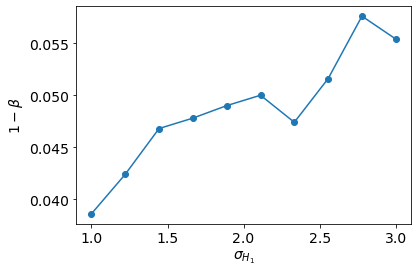

In [16]:
plt.plot(sigma_range,powers,marker='o')
plt.xlabel("$\sigma_{H_{1}}$")
plt.ylabel("$1-\\beta$")
plt.show()

## 2-sample KS test

The 2-sample KS test  is needed when you want to compare two distributions in data and do not have a model. In this case, we want to know if the two distributions in data come from the same underlying model or not. In this case our $H_{0}$ is the hypothesis that they are the *same* underlying distribution. 

We'll be looking at an example from particle physics where we've trained a Boosted Decision tree (BDT), designed to separate a new Higgs boson decaying to photons $H\rightarrow \gamma\gamma$ from a very large background. 

I have some simulated events of $H\rightarrow \gamma\gamma$ where for each event, I have evaluated the BDT and put the resulting values in a dataframe. When you come to work with classifiers (such as BDTs or neural-networks), you'll find that you often want to use some data to train the model, and some to test its performance. You'll learn that sometimes these models can be *over-trained* meaning that instead of learning the underlying model, the BDT or network has instead learned the particular features of the data used to train it. Comparing the distribution of the output of the BDT (or neural-network) from data used to train and an independent  data set is a great way to test if the model is overtrained.  

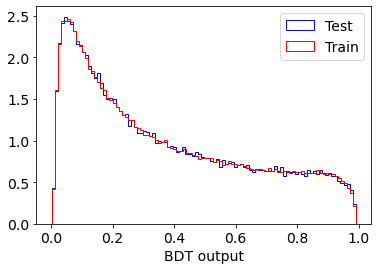

In [17]:
data_train = pandas.read_csv("Hgg_VBF_BDT_train.csv")
data_train = data_train['train_scores'].to_numpy()

data_test = pandas.read_csv("Hgg_VBF_BDT_test.csv")
data_test = data_test['test_scores'].to_numpy()

plt.hist(data_test,color='blue',histtype='step',density="True",bins=100,label='Test')
plt.hist(data_train,color='red',histtype='step',density="True",bins=100,label='Train')
plt.xlabel("BDT output")
plt.legend()
plt.show()

And we can compare the emprical CDFs for both. 

Text(0, 0.5, '$F(BDT)$')

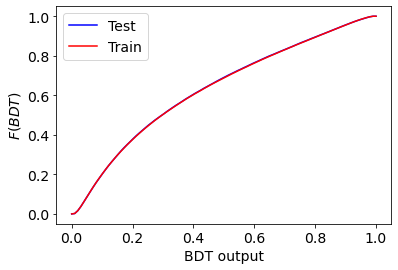

In [18]:
xrange = numpy.linspace(0,1,100)
plt.plot(xrange,[emp_cdf(data_test,x) for x in xrange],color='blue',label='Test')
plt.plot(xrange,[emp_cdf(data_train,x) for x in xrange],color='red',label='Train')
plt.legend()
plt.xlabel("BDT output")
plt.ylabel("$F(BDT)$")

In the 2-sample KS test, our test-statistic is based on the two empirical CDFs, one for each dataset. 

$$
D_{2} = \mathrm{sup}_{x}\left|F_{test data}(x)-F_{train data}(x)\right|
$$


In [19]:
def D2(data_test,data_train):
    diffs = [abs(emp_cdf(data_test,x)-emp_cdf(data_train,x)) for x in xrange]
    return max(diffs)

D2_data = D2(data_test,data_train)
print("D2_data for 2-sample KS=",D2_data)

D2_data for 2-sample KS= 0.002559906481293006


But how do we know if this value in data is typical under the assumption that the two distributions originate from the same underlying distribution or not? Again we need to know the distribution of $D_{2}$ under $H_{0}$. 

We can assume that the most likely distribution that they are both distributed as is the average of the two distributions. So we make a new dataset combining the two, and use bootstrapping to estimate the distribution of $D_{2}$ (it might take a little while to run)

In [20]:
data_all = numpy.append(data_test,data_train)

D2bs = []
nsamples  = 100

for sample in range(nsamples):
 bootstrap_test  = numpy.array(random.choices(data_all,k=len(data_test)))
 bootstrap_train = numpy.array(random.choices(data_all,k=len(data_train)))
 D2bs.append(D2(bootstrap_test,bootstrap_train))

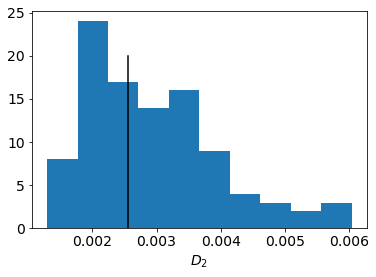

In [21]:
plt.hist(D2bs,bins=10)
plt.xlabel("$D_{2}$")
plt.plot([D2_data,D2_data],[0,20],color='black')
plt.show()

Again, the data value of $D_{2}$ is well inside the distribution (will not be in the critical region) so we cannot reject the $H_0$ hypothesis. 